In [1]:
import glob
import matplotlib as mpl
import matplotlib.colors 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.optimize as spopt
import scipy.stats as spstats

import populationevolution_v5 as popev

np.random.seed(42)
plt.style.use(('C:\\Users\\Nicholas Sherer\\.matplotlib\\Sherer_Thesis.mplstyle'))
%matplotlib inline

In [2]:
def logNbarplot(ax, pop):
    mu = pop.mutation_list.flatten()
    f = pop.fitness_list.flatten()
    N = pop.population_distribution
    xmesh, ymesh = np.meshgrid(np.arange(mu.size),-np.arange(f.size))
    xmesh = xmesh.ravel()
    ymesh = ymesh.ravel()
    logN = np.maximum(0,np.log(N.flatten()))
    bottom = np.zeros_like(logN)
    width=1
    depth=1
    ax.bar3d(xmesh, ymesh, bottom, width, depth, logN, shade=True);
    ax.view_init(elev = 45, azim=45);
    ax.set_xticklabels('{:2g}'.format(m) for m in mu);
    ax.set_yticks(-np.arange(f.size))
    ax.set_yticklabels(['{:2g}'.format(f_) for f_ in f], fontsize='medium')
    zticks = ax.get_zticks()
    ax.set_zticklabels('{0:.2g}'.format(np.exp(v)) for v in zticks)
    
def logNvsfplot(ax, pop):
    f_list = pop.fitness_list.flatten()
    N_f = np.sum(pop.population_distribution, axis=1)
    ind = np.arange(f_list.size,0,-1)
    ax.bar(ind, N_f, width=.95)
    ax.set_yscale('log')
    ax.set_xticks(ind[::2]);
    ax.set_xticklabels(['{:1g}'.format(f) for f in f_list][::2]);
    ax.set_xlabel('fitness, $f$', fontsize=32)
    ax.set_ylabel('$N(f)$', fontsize=32)
    
def logNvsmuplot(ax, pop):
    mu_list = pop.mutation_list.flatten()
    N_mu = np.sum(pop.population_distribution, axis=0)
    ind = np.arange(mu_list.size)
    ax.bar(ind, N_mu, width=.95)
    ax.set_yscale('log')
    ax.set_xticks(ind[::2]);
    ax.set_xticklabels(['{:1g}'.format(mu) for mu in mu_list][::2]);
    ax.set_xlabel('mutation rate, $\mu$', fontsize=32)
    ax.set_ylabel('$N(\mu)$', fontsize=32)

In [3]:
def mean_df_dt(pop, t_start=None, t_end=None):
    if t_start is None and t_end is None:
        pop_slice = slice(None,None,None)
    elif t_start is None:
        pop_slice = slice(None, t_end, None)
    elif t_end is None:
        pop_slice - slice(t_start, t_end, None)
    f = pop.mean_fitness[pop_slice]
    t = np.arange(f.size)
    m, b = np.polyfit(t, f, 1)
    return m

def mean_and_std_by(xs, ys):
    if len(xs) != len(ys):
        raise ValueError('xs and ys must have the same length')
    collect_dict = {}
    for i, x in enumerate(xs):
        try:
            collect_dict[x].append(ys[i])
        except KeyError:
            collect_dict[x]=[]
    mean_dict = {}
    std_dict = {}
    for key in collect_dict:
        mean_dict[key]=np.mean(collect_dict[key])
        std_dict[key]=np.std(collect_dict[key])
    keys = np.array(list(mean_dict.keys()))
    sort = np.argsort(keys, axis=None)
    return keys[sort], np.array(list(mean_dict.values()))[sort], np.array(list(std_dict.values()))[sort]

# Load Data

In [4]:
fbvary_results = []
for file in glob.glob('evolved_mu_f_b_vary?replicate?datetime.datetime(2019, 5, *).hdf5'):
    try:
        fbvary_results.append(popev.PopulationReader(file))
    except OSError:
        pass

favary_results = []
for file in glob.glob('evolved_mu_f_a_vary?replicate?datetime.datetime(2019, 5, *).hdf5'):
    try:
        favary_results.append(popev.PopulationReader(file))
    except OSError:
        pass

delta_f_vary_results = []
for file in glob.glob('evolved_mu_delta_f_vary?replicate?datetime.datetime(2019, 5, *).hdf5'):
    try:
        delta_f_vary_results.append(popev.PopulationReader(file))
    except OSError:
        pass
    
K_vary_results = []
for file in glob.glob('evolve_mu_K_vary?replicate?datetime.datetime(2019, 6, *).hdf5'):
    try:
        K_vary_results.append(popev.PopulationReader(file))
    except OSError:
        pass

In [6]:
len(fbvary_results[0])

5000000

In [5]:
cd Thesis_Data_and_Figures/

E:\Documents\Python Evolution Simulation\Population Evolution Project Source Code\Thesis_Data_and_Figures


# Graphs of population distribution and trajectories for base parameter set

In [6]:
basepop = fbvary_results[50]
print('The parameters of the base population are delta_f: {},'
      ' M: {}, P_b: {}, P_a: {}, P_mu: {}, K: {}'.format(basepop.delta_fitness, basepop.mu_multiple,
                                                        basepop.fraction_beneficial, basepop.fraction_accurate,
                                                        basepop.fraction_mu2mu, basepop.pop_cap))

The parameters of the base population are delta_f: 0.03, M: 2, P_b: 0.0001, P_a: 0.0001, P_mu: 0.1, K: 1000000


Given a delta_f of .03 and a K of 1 million, we expect it would take about 450 generations for a new mutation increasing fitness by one step to fix after it invades the population

E:\Anaconda3\envs\imageprocessing_windows\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


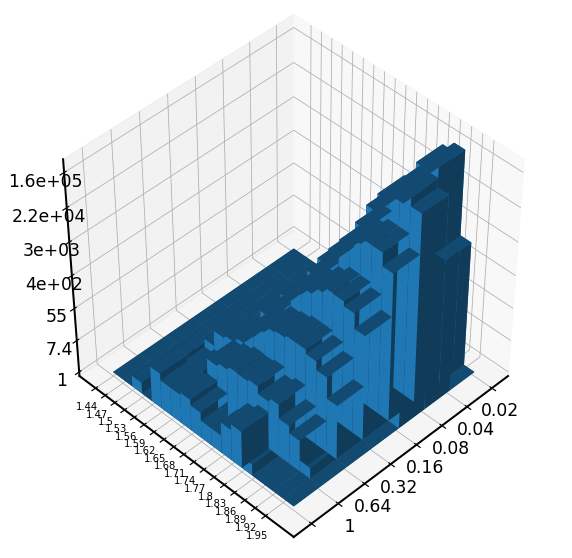

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
logNbarplot(ax, basepop(15000))
plt.savefig('traveling_wave_full_distribution.pdf')

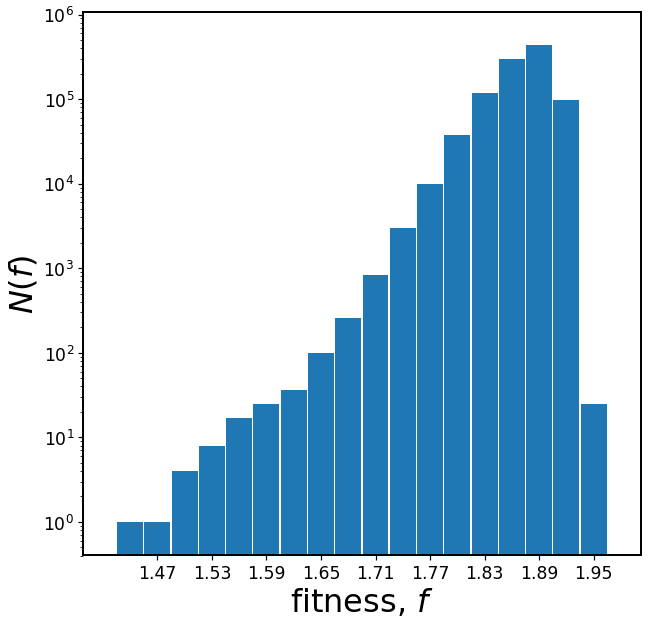

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
logNvsfplot(ax, basepop(15000))
plt.savefig('traveling_wave_f_distribution.pdf')

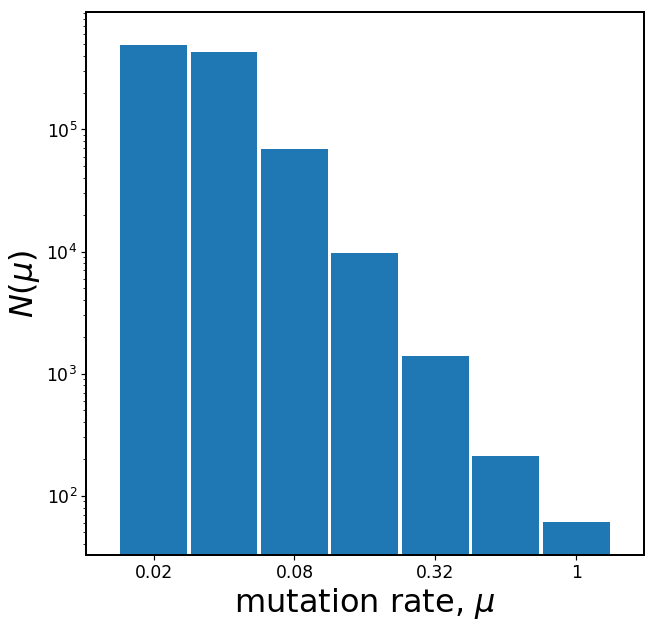

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
logNvsmuplot(ax, basepop(15000))
plt.savefig('traveling_wave_mu_distribution.pdf')

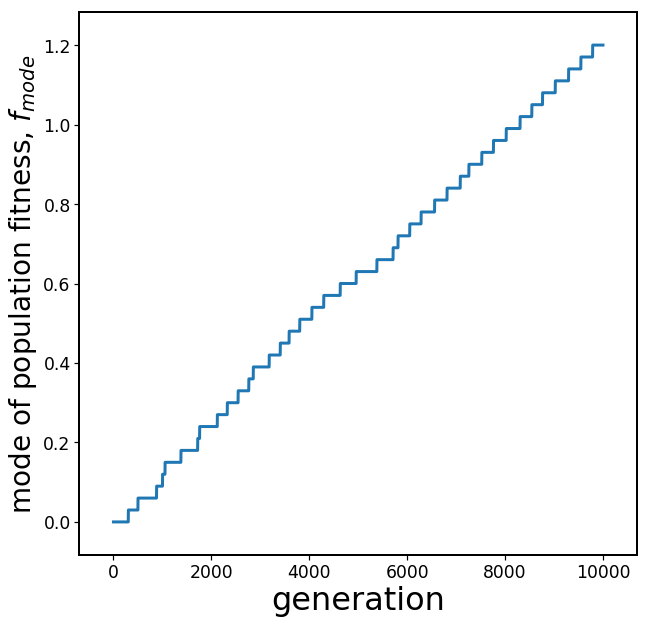

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(basepop.mode_fitness[:10000], marker='');
ax.set_xlabel('generation', fontsize=32);
ax.set_ylabel('mode of population fitness, $f_{mode}$', fontsize=28);
plt.savefig('traveling_wave_f_evolution.pdf')

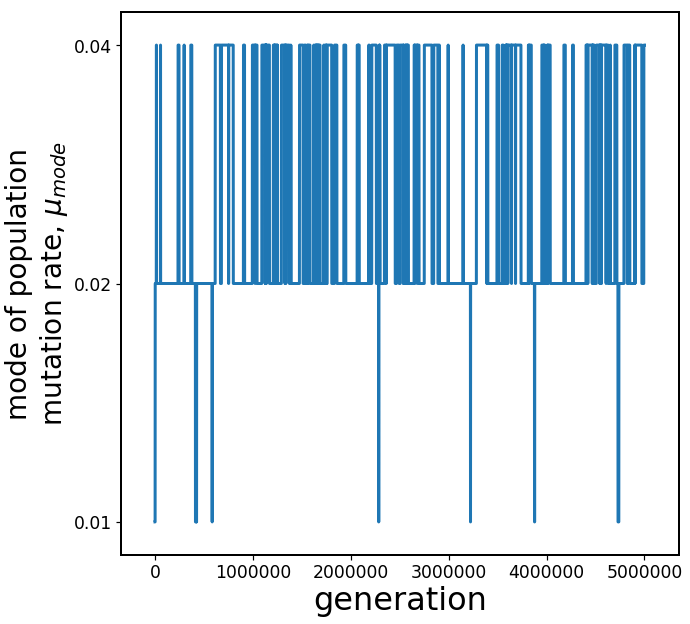

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.semilogy(basepop.mode_mutation_rate[:], marker='');
ax.minorticks_off()
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks(np.unique(basepop.mode_mutation_rate[:]))
ax.set_xlabel('generation', fontsize=32);
ax.set_ylabel('mode of population\nmutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('traveling_wave_mu_evolution.pdf')

# Varying the probability of beneficial mutations

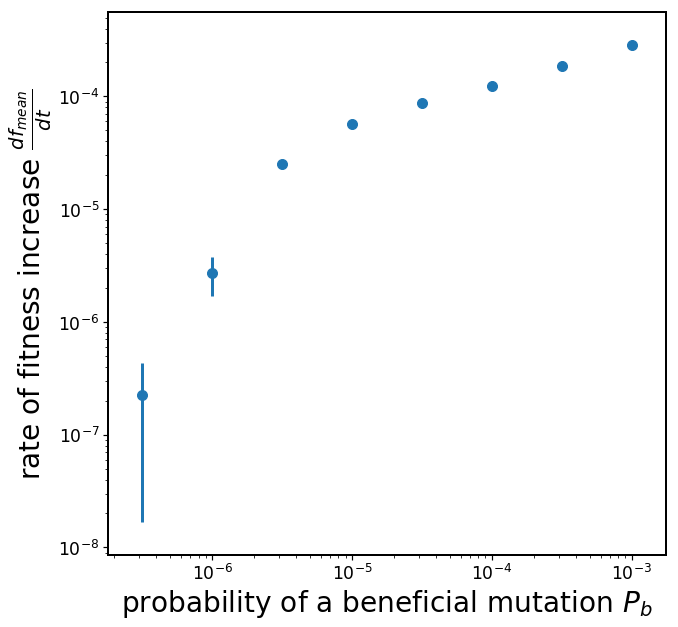

In [12]:
fbs = [pop.fraction_beneficial for pop in fbvary_results]
dfdts = [mean_df_dt(pop) for pop in fbvary_results]
fbs, mean_dfdts, std_dfdts = mean_and_std_by(fbs, dfdts)

fig = plt.figure(figsize=(10,10))
plt.errorbar(fbs, mean_dfdts, 2*std_dfdts, linestyle='');
plt.xscale('log')
plt.yscale('log')
plt.xlabel('probability of a beneficial mutation $P_{b}$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_P_b.pdf')

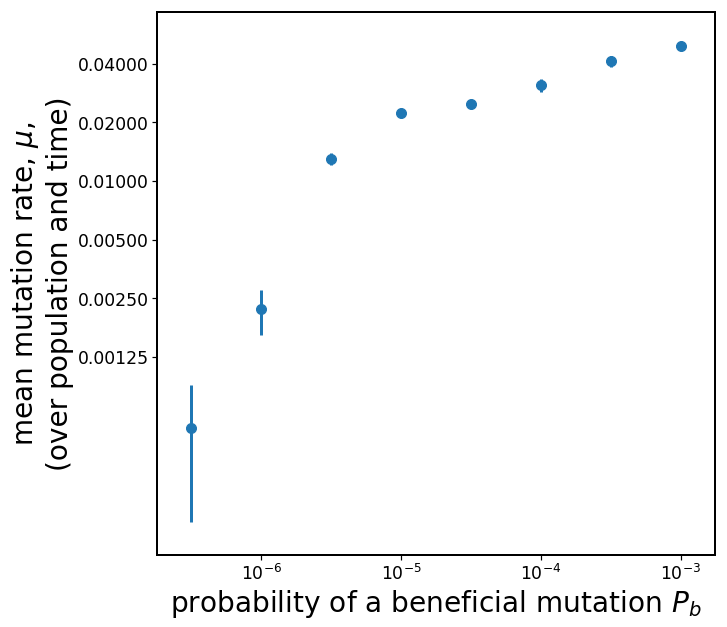

In [13]:
fbs = [pop.fraction_beneficial for pop in fbvary_results]
mu_avs = [np.mean(pop.mean_mutation_rate[:]) for pop in fbvary_results]
fbs, mean_mu_avs, std_mu_avs = mean_and_std_by(fbs, mu_avs)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(fbs, mean_mu_avs, 2*std_mu_avs, linestyle='')
ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_off()
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([.00125, .0025, .005, .01, .02, .04])
ax.set_xlabel('probability of a beneficial mutation $P_{b}$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_P_b.pdf')

# Varying the probability of accurate mutations

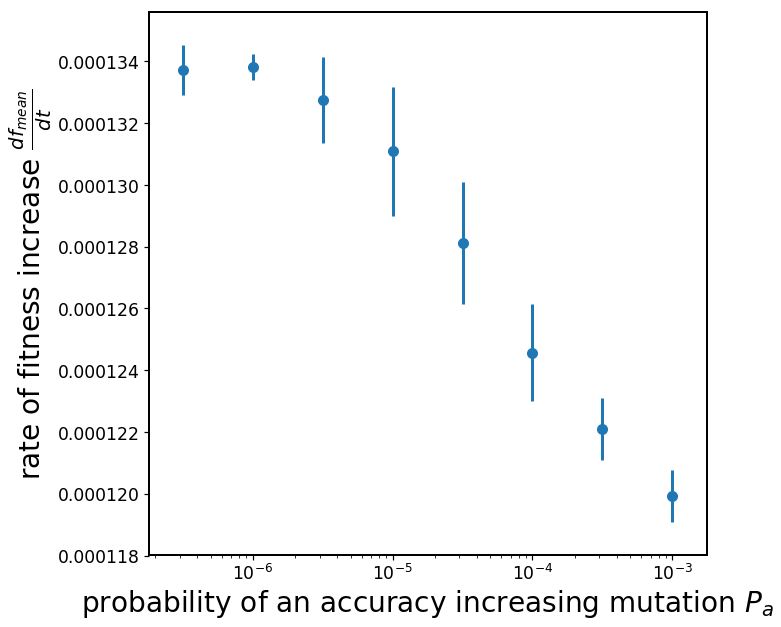

In [14]:
fas = [pop.fraction_accurate for pop in favary_results]
dfdts = [mean_df_dt(pop) for pop in favary_results]
fas, mean_dfdts, std_dfdts = mean_and_std_by(fas, dfdts)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(fas, mean_dfdts, 2*std_dfdts, linestyle='')
ax.set_xscale('log')
ax.set_xlabel('probability of an accuracy increasing mutation $P_{a}$', fontsize=28);
ax.set_ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_P_a.pdf')

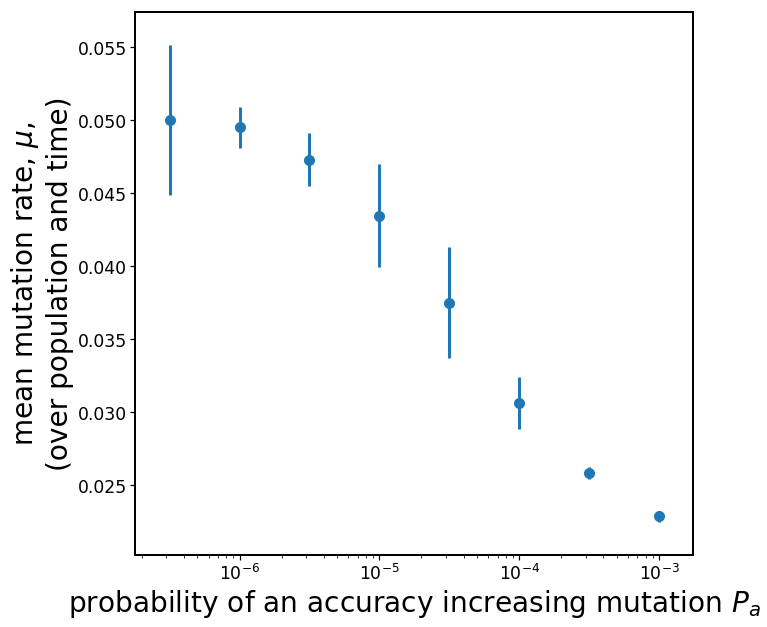

In [15]:
fas = [pop.fraction_accurate for pop in favary_results]
mu_avs = [np.mean(pop.mean_mutation_rate[:]) for pop in favary_results]
fas, mean_mu_avs, std_mu_avs = mean_and_std_by(fas, mu_avs)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(fas, mean_mu_avs, 2*std_mu_avs, linestyle='')
ax.set_xscale('log')
ax.set_xlabel('probability of an accuracy increasing mutation $P_{a}$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_P_a.pdf')

# Varying $\Delta f$

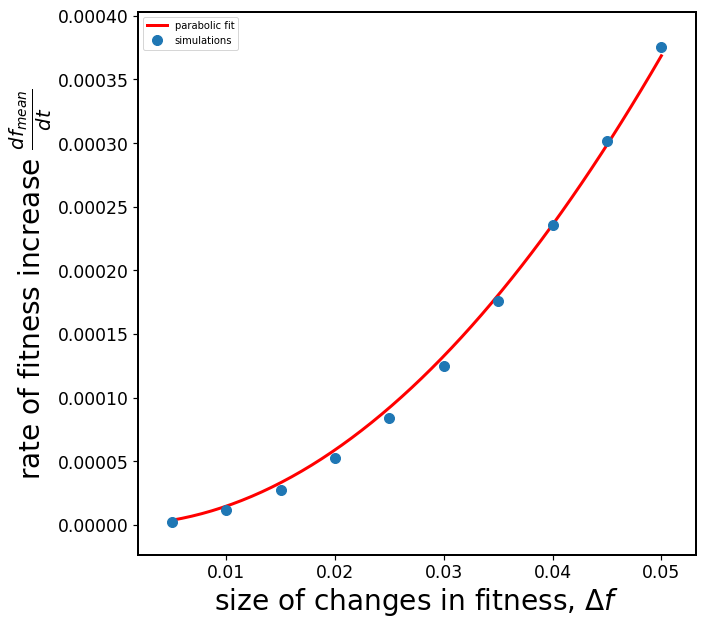

In [22]:
delta_fs = [pop.delta_fitness for pop in delta_f_vary_results]
dfdts = [mean_df_dt(pop) for pop in delta_f_vary_results]
delta_fs, mean_dfdts, std_dfdts = mean_and_std_by(delta_fs, dfdts)


fig = plt.figure(figsize=(10,10))
plt.errorbar(delta_fs, mean_dfdts, 2*std_dfdts, linestyle='', label='simulations')

def parabola(x, a):
    return a*x**2
popt, pcov = spopt.curve_fit(parabola,
                             np.array([pop.delta_fitness for pop in delta_f_vary_results]),
                             np.array([mean_df_dt(pop) for pop in delta_f_vary_results]))
effs = np.linspace(.005,.05)
plt.plot(effs, parabola(effs,*popt), 'r', marker='', label='parabolic fit')
plt.xlabel('size of changes in fitness, $\Delta f$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.legend()
plt.savefig('df_dt_varying_delta_f.pdf')

In [21]:
popt

array([ 1.67988134e-01, -9.53442041e-04,  3.67405221e-06])

In [23]:
popt

array([0.14740233])

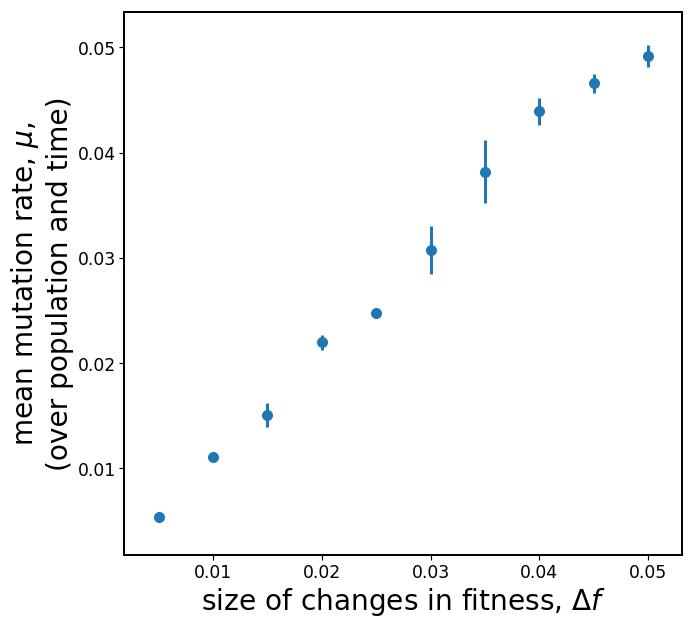

In [17]:
delta_fs = [pop.delta_fitness for pop in delta_f_vary_results]
mu_avs = [np.mean(pop.mean_mutation_rate[:]) for pop in delta_f_vary_results]
delta_fs, mean_mu_avs, std_mu_avs = mean_and_std_by(delta_fs, mu_avs)

fig = plt.figure(figsize=(10,10))
plt.errorbar(delta_fs, mean_mu_avs, 2*std_mu_avs, linestyle='')
plt.xlabel('size of changes in fitness, $\Delta f$', fontsize=28);
plt.ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_delta_f.pdf')

# Varying K

The population size changed due to a bug in all the simulations where N = 10^10. Because of this, it is necessary to cut off the last set of simulations for K=10^10

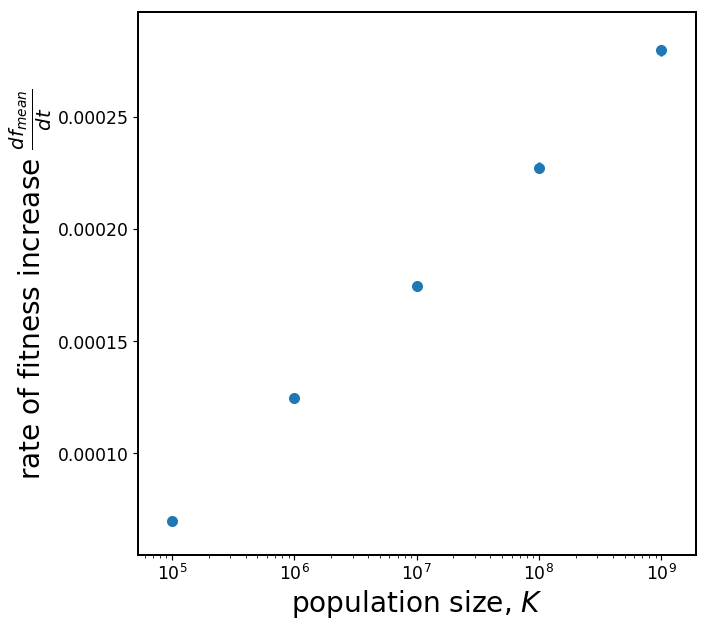

In [18]:
Ks = [pop.pop_cap for pop in K_vary_results]
dfdts = [mean_df_dt(pop) for pop in K_vary_results]
Ks, mean_dfdts, std_dfdts = mean_and_std_by(Ks, dfdts)

fig = plt.figure(figsize=(10,10))
plt.errorbar(Ks[:-1], mean_dfdts[:-1], 2*std_dfdts[:-1], linestyle='')
plt.xscale('log')
plt.xlabel('population size, $K$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_K.pdf')

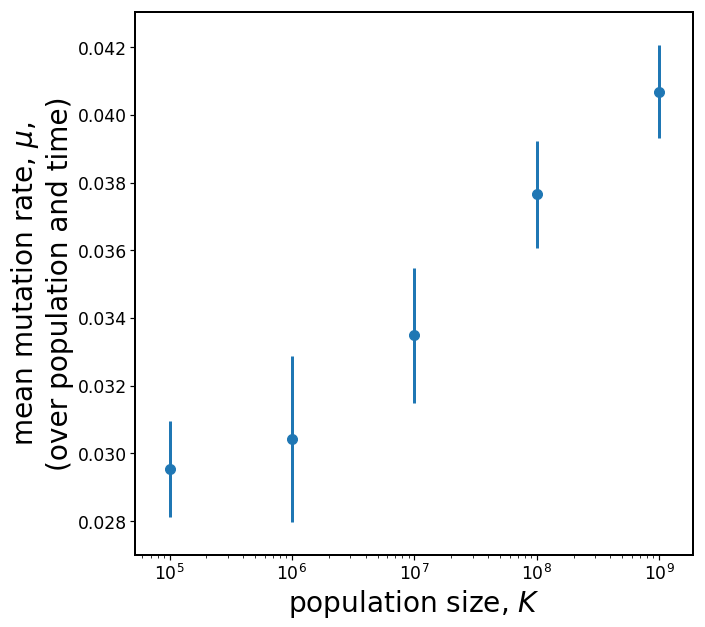

In [19]:
Ks = [pop.pop_cap for pop in K_vary_results]
mu_avs = [np.mean(pop.mean_mutation_rate[:]) for pop in K_vary_results]
Ks, mean_mu_avs, std_mu_avs = mean_and_std_by(Ks, mu_avs)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(Ks[:-1], mean_mu_avs[:-1], 2*std_mu_avs[:-1], linestyle='')
ax.set_xscale('log')
ax.set_xlabel('population size, $K$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_K.pdf')

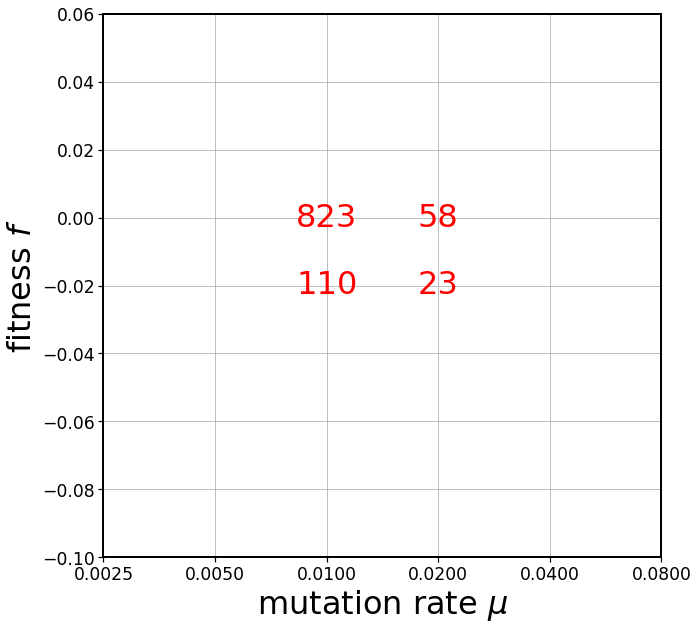

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_ylim(-.1,.06)
ax.set_yticks(np.linspace(-.1,.06,9))
ax.set_xlim(.01/4,.04)
ax.set_xscale('log')
ax.minorticks_off()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([.01/4, .01/2, .01, .02, .04, .08])
ax.grid(True)
ax.text(.01, 0, '823', ha='center', va='center', fontsize=32, color='red')
ax.text(.01, -.02, '110', ha='center', va='center', fontsize=32, color='red')
ax.text(.02, 0, '58', ha='center', va='center', fontsize=32, color='red')
ax.text(.02, -.02, '23', ha='center', va='center', fontsize=32, color='red')
ax.set_xlabel('mutation rate $\mu$', fontsize=32)
ax.set_ylabel('fitness $f$', fontsize=32)
plt.savefig('example_fitness_and_mu_layout.pdf')